v0 + :
- full training process for bigram

Source:
- https://youtu.be/kCc8FmEb1nY
- https://github.com/karpathy/ng-video-lecture/blob/master/bigram.py

In [1]:
import os; os.chdir('..')
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.nn import functional as F

from utils import *
from boring_utils.utils import init_graph, set_seed, get_device, cprint, tprint
from utils import add_to_class

In [4]:
init_graph()

# Hyperparameters

In [5]:
set_seed(1337)
batch_size = 32 # how many independent sequences to train on in parallel
block_size = 8  # what is the maximum concatenated length for predictions
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
device = get_device()
eval_iters = 200

# Encode and Decode Funcion

In [6]:
input_file_path = './data/shakespeare_char/input.txt'

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
print("stoi:", stoi)
print("itos:", itos)

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers

def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
stoi: {'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
itos: {0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q'

In [7]:
def test_decode(net, max_new_tokens=100):
    gen = net.generate(
            torch.zeros((1, 1), dtype=torch.long, device=device),
            max_new_tokens=max_new_tokens
        )
    print(gen)
    print(decode(gen[0].tolist()))

In [8]:
train_bin_path = './data/shakespeare_char/train.bin'
val_bin_path = './data/shakespeare_char/val.bin'

# train_tensor = torch.tensor(encode(data), dtype=torch.long) # convert to tensor

# torch.long is just an alias for torch.int64
# load the binary data
train_data = np.fromfile(train_bin_path, dtype=np.uint16)
val_data = np.fromfile(val_bin_path, dtype=np.uint16)

# convert to pytorch tensors
train_tensor = torch.from_numpy(train_data.astype(np.int64))
val_tensor = torch.from_numpy(val_data.astype(np.int64))

print(train_tensor.shape, train_tensor.dtype)
print(val_tensor.shape, val_tensor.dtype)


torch.Size([1003854]) torch.int64
torch.Size([111540]) torch.int64


# Train Test Split

In [9]:
# check utils.get_batch

# NN
Another thing to notice is `nn.Embedding` behaves the same during training and inference mode

In [10]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        embedding_dim = vocab_size
        # embedding_dim = 128
        # each token is represented by a one-hot vector
        # directly reads off the logits for the next token from the embedding table
        # for example: 24 will reads off the 24th column of the embedding table
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, idx, targets=None):
        # idx is (batch_size, block_size)
        logits = self.embedding(idx)  # B, T, C: (batch_size, block_size, embedding_dim)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)  # (batch_size * block_size, embedding_dim)
            targets = targets.view(-1)  # (batch_size * block_size)
            loss = F.cross_entropy(logits, targets)

        return logits, loss


`-ln(1/65)` is essentially the baseline or the "no information" rate. Any model should ideally perform better than this.

A lower loss means that the model's predictions are better than random guessing. A higher loss means the model's predictions are worse than random guessing. 

Cross entropy loss = `-sum(y_i * log(p_i))` for all classes `i`. 
Where `y_i` is the true label (1 for the correct class and 0 for all other classes), and `p_i` is the predicted probability for class `i` (random selection `p_i` = 1/65).


In [11]:
# in prepare.py, we have:
# chars = sorted(list(set(data)))
# vocab_size = len(chars)

m = BigramLanguageModel(65)
m.to(device)
# logits, loss = m(xb, yb)
# print(logits.shape, logits.dtype)
# print(loss)  # so currently this is worse than random guessing

BigramLanguageModel(
  (embedding): Embedding(65, 65)
)

In [12]:
@add_to_class(BigramLanguageModel)
def generate(self, idx, max_new_tokens):
    # idx is (batch_size, block_size)
    for _ in range(max_new_tokens):
        # get the predictions
        # logits, _ = self.forward(idx, None)
        logits, _ = self(idx)

        # focus only the last time stemp
        logits = logits[:, -1, :]  # (batch_size, embedding_dim)
        probs = F.softmax(logits, dim=-1)

        # sample from distrubution
        idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # append sampled idx to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, T + 1)

    return idx

In [13]:
test_decode(m)

tensor([[ 0, 31, 23, 21, 41, 24, 32, 11, 13, 41, 17, 24, 25, 53, 32, 40, 60, 38,
         60,  1, 15, 12, 52, 55,  7, 29, 17,  9,  9, 10, 15, 22, 55, 49, 27, 23,
         20,  7, 55, 11, 10, 50, 39,  2, 53, 47, 63, 61, 49, 20, 48, 45, 15, 46,
         64, 40, 29, 12, 59,  2,  9, 40, 24, 21, 45, 61, 43, 60, 51, 63, 18, 22,
         19, 33, 19, 54,  0, 61, 52, 37, 35, 51, 52, 62, 23, 35, 35, 43, 60,  7,
         58, 16, 55, 36, 17, 56, 34, 23, 24, 45, 22]])

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


# Training the NN

[torch.optim.Optimizer.zero_grad — PyTorch 2.0 documentation](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)

In [14]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [15]:
loss_list = []

for steps in range(max_iters):
    if steps % eval_interval == 0:
        # in fp16 mode, we use autocast to automatically cast the data to half precision
        # ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
        losses = estimate_loss_np(m, eval_iters, train_data, val_data, device=device)
        print(f"step: {steps}, train loss: {losses['train']:.4f}, val loss: {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch_np(train_data, device=device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    # interesting...
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if steps % 200 == 0:
        loss_list.append(loss.item())


step: 0, train loss: 4.7268, val loss: 4.7237
step: 300, train loss: 4.2959, val loss: 4.2949
step: 600, train loss: 3.9258, val loss: 3.9280
step: 900, train loss: 3.6159, val loss: 3.6205
step: 1200, train loss: 3.3609, val loss: 3.3674
step: 1500, train loss: 3.1558, val loss: 3.1637
step: 1800, train loss: 2.9937, val loss: 3.0033
step: 2100, train loss: 2.8663, val loss: 2.8778
step: 2400, train loss: 2.7688, val loss: 2.7824
step: 2700, train loss: 2.6948, val loss: 2.7093


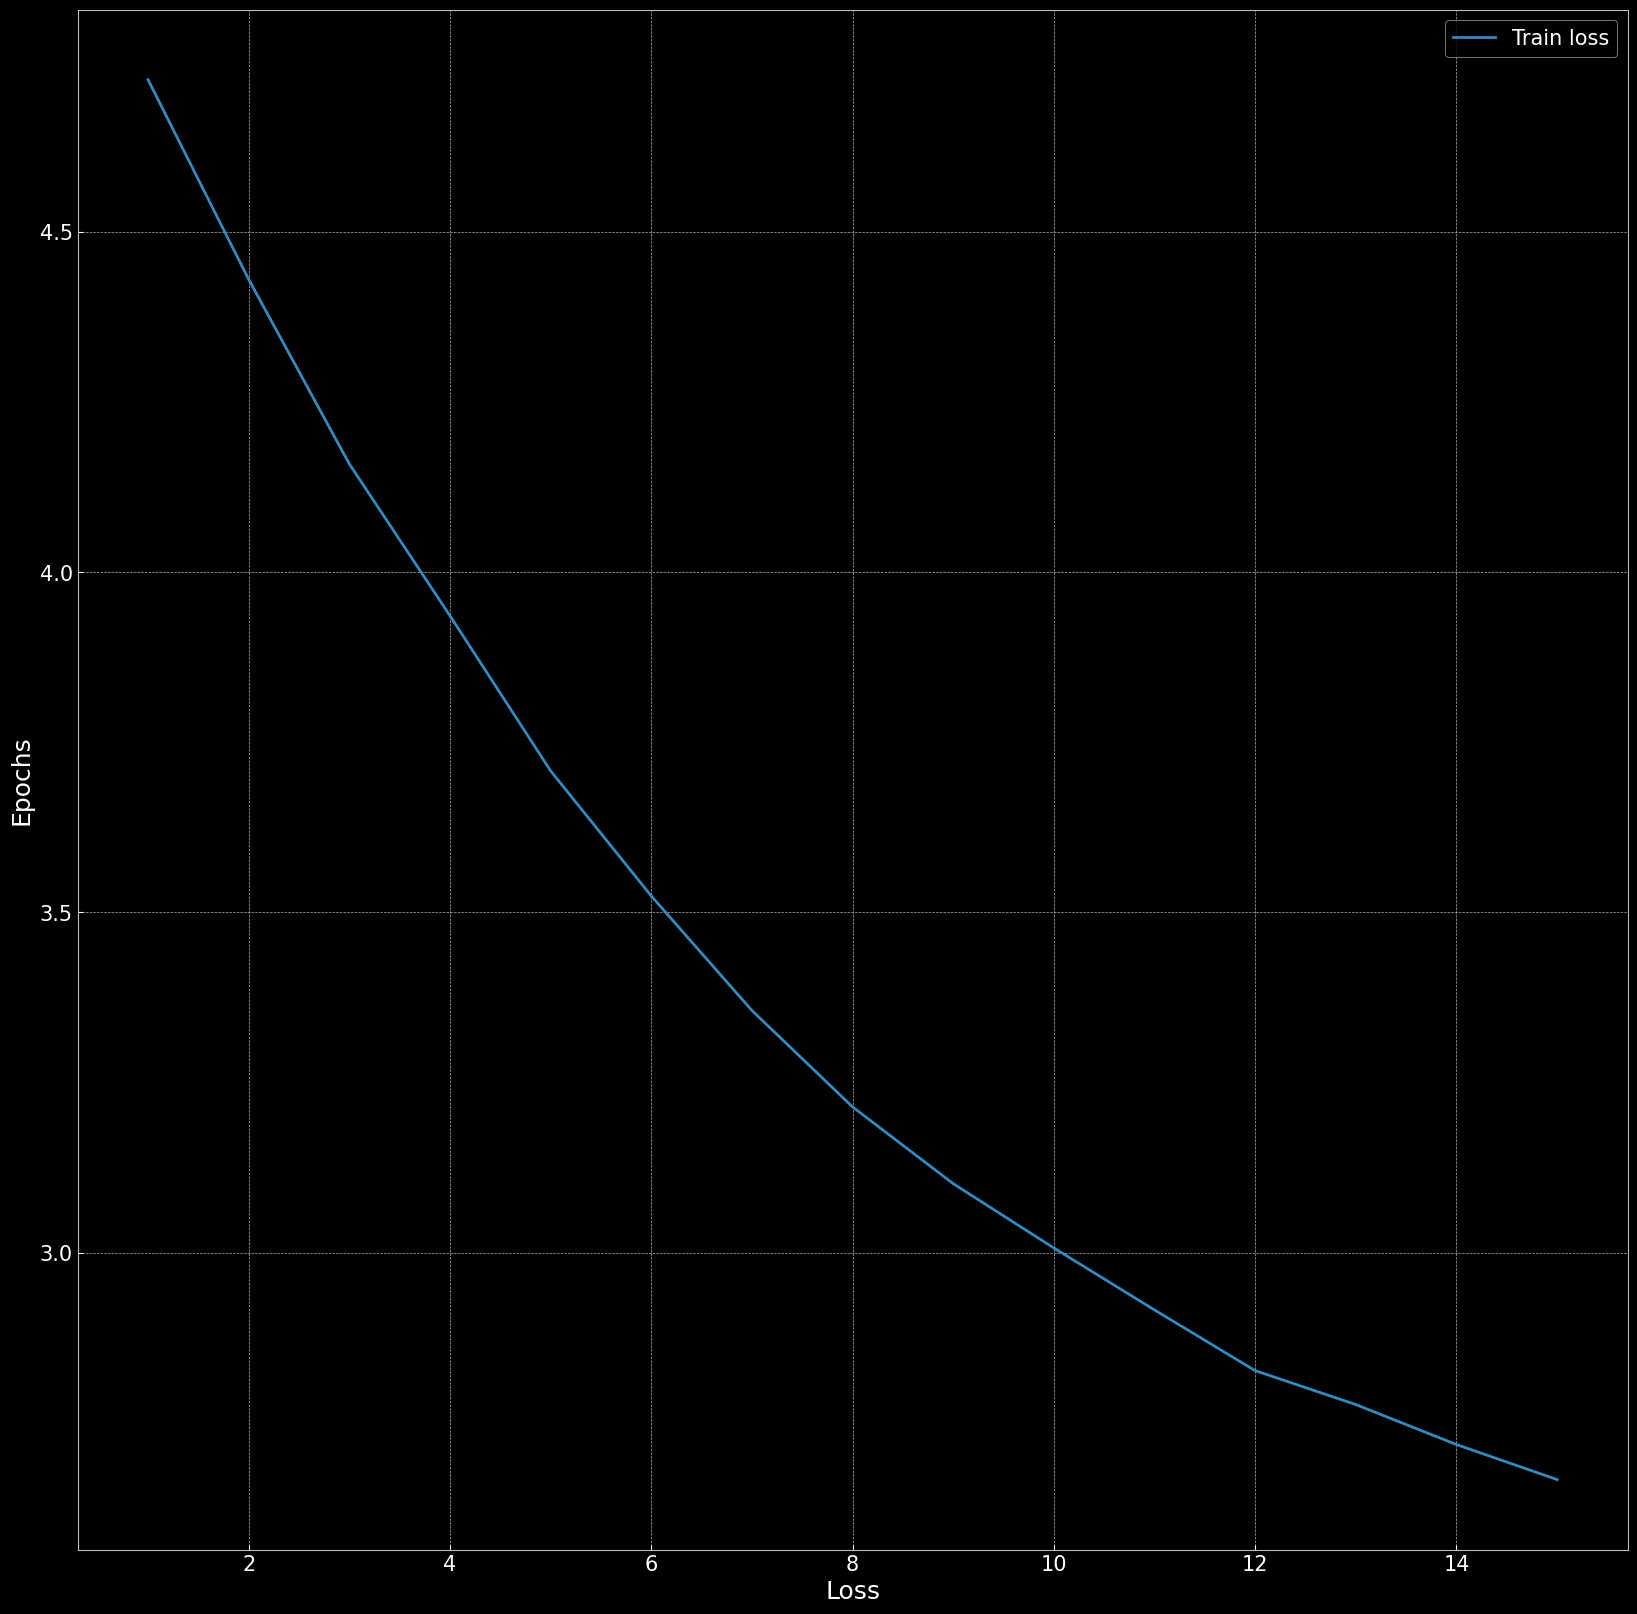

In [16]:
fig = plt.figure(figsize=(20, 20))
plt.plot(np.arange(1, len(loss_list) + 1), loss_list, label="Train loss")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend(loc="upper right")

plt.show()

In [17]:
test_decode(m, 500)

tensor([[ 0, 25,  3, 17, 30, 33, 19, 36, 23, 17, 24, 29, 12, 32, 46, 63,  1, 58,
         46, 22, 33, 32, 46, 57, 56, 43, 39, 51, 47, 52, 36, 47, 28, 27, 24, 21,
          1, 44, 50, 39, 52, 53,  1, 63,  1, 55, 59,  1, 61, 53, 52, 42,  1, 40,
         43,  1, 48, 28, 33, 15, 53,  8,  0, 20, 49, 43,  1, 39, 58, 53, 58, 46,
         53,  1, 61, 47, 40, 40, 48, 53, 50, 45,  1, 57,  6,  1, 54, 54, 39, 58,
         30, 27, 24, 22, 24, 33, 12,  4, 40, 50, 21, 33, 30, 17, 31, 10, 54,  5,
         57, 46, 43, 58, 43, 57,  1, 42,  1, 57,  3, 53,  1, 45, 38, 17, 26, 53,
         51, 43, 56,  1, 54, 50,  1, 51, 63,  1, 46, 39, 60, 40, 39, 57, 53, 52,
         43,  1, 51, 39, 52, 39, 51, 39, 54, 39, 63,  1, 44, 53,  1, 15, 20, 53,
         62, 41, 43, 46, 43,  1, 51, 39, 50, 39, 50, 63, 62,  2,  0, 16, 59, 18,
         56,  8,  0, 18, 36, 17,  7,  7, 51, 53, 59,  1, 21,  1, 58,  1, 50,  1,
         53,  5, 42, 42, 59, 45, 43,  1,  4, 53, 52, 42, 59,  1, 57, 56, 45, 56,
         47, 56, 39, 60,  2,